In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml



Now we want to start tracking particles!
First of all let's load the collider and build the trackers.

Then we want to set the optics from a config file.
We will use the optics from the HL-LHC config.

In [2]:
collider = xt.Multiline.from_json('../data/collider_thin.json')
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


In [3]:
with open('../data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
def set_orbit_from_config(collider, config):

    print('Setting optics as from config')
    for ii in ['on_x1', 'on_sep1', 'on_x2', 'on_sep2', 'on_x5',
               'on_sep5', 'on_x8h', 'on_x8v', 'on_sep8h', 'on_sep8v',
               'on_a1', 'on_o1', 'on_a2', 'on_o2', 'on_a5', 'on_o5', 'on_a8', 
               'on_o8', 'on_disp', 'on_crab1', 'on_crab5', 'on_alice_normalized', 
               'on_lhcb_normalized', 'on_sol_atlas', 'on_sol_cms', 'on_sol_alice', 
               'vrf400', 'lagrf400.b1', 'lagrf400.b2']:
        if "on_crab" in ii:
             collider.vars[ii] = 0
        else:
            collider.vars[ii] = config['config_collider']['config_knobs_and_tuning']['knob_settings'][ii]
set_orbit_from_config(collider, config)
twiss_b1 = collider['lhcb1'].twiss(method ='4d', freeze_longitudinal = True)
line = collider['lhcb1']
line.cycle(f"ip1", inplace=True)
#line.freeze_vars(['delta'])
#for i in range(len(line.twiss().delta)):
#    line.twiss().delta[i] = 0
print(twiss_b1.delta)

''' 
for ii in line.elements:
   # if ii is a type 'multipole' 
   
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0
'''


Setting optics as from config
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.
[0. 0. 0. ... 0. 0. 0.]


" \nfor ii in line.elements:\n   # if ii is a type 'multipole' \n   \n    if type(ii) == xt.beam_elements.elements.Multipole:\n        if len(ii.knl)>2:\n            #print(ii)\n            ii.knl[2] = 0\n"

Text(0.5, 1.0, 'Closed orbit')

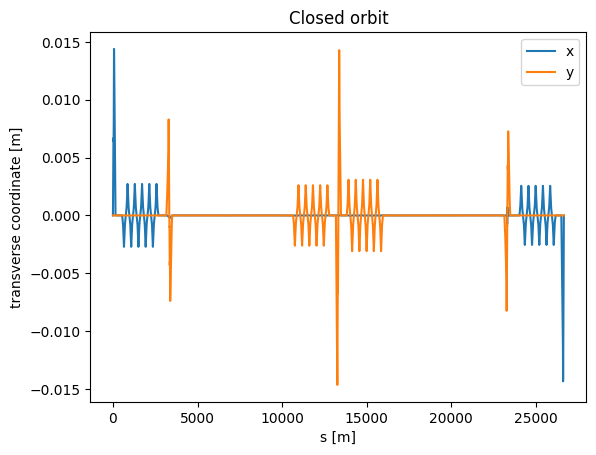

In [4]:
tw0 = collider.lhcb1.twiss()
fig, ax = plt.subplots()
plt.plot(tw0.s, tw0.x, label='x')
plt.plot(tw0.s, tw0.y, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('transverse coordinate [m]')
plt.title('Closed orbit')

In [5]:
tw0[:, "ip8"]["px"]*1e6

array([134.99897769])

In [6]:
line.get_s_position("ip1")


0

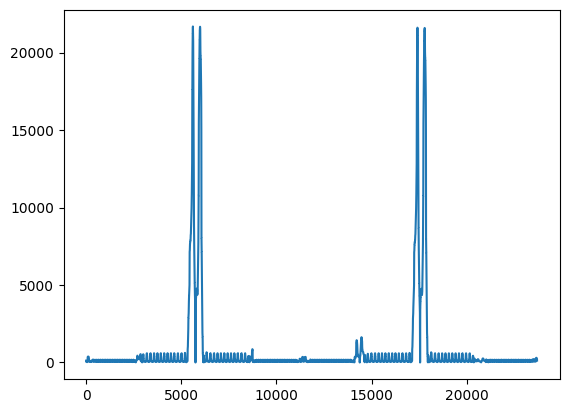

-0.47543522318096854
0.15018994085144075


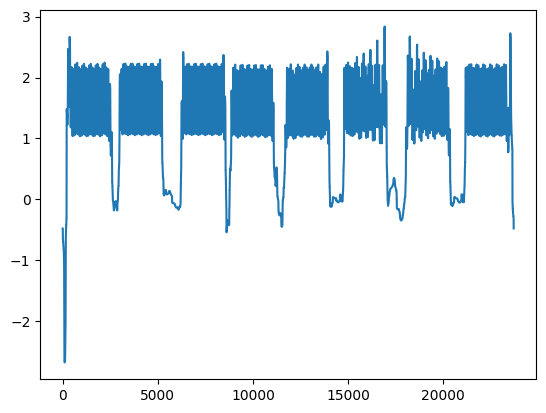

In [7]:
betx = twiss_b1['betx']
plt.plot(betx)
plt.show()
betx_ip1 = twiss_b1['betx', 'ip1']
d = twiss_b1.dx
plt.plot(d)
print(d[0])

print(betx_ip1)

In [8]:
ctx = xo.ContextCpu()
N_particles = 10000
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = line)




gaussian_bunch.zeta = 0.0
gaussian_bunch.delta = 0.0



*** Maximum RMS bunch length 0.11789515101464536m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.07499981826886956
--> Emittance: 2.1273543493291487


In [9]:
tw0[:,0]["dx" ,  'ip1']


-0.0012114801089013576

In [10]:

tw0 = collider['lhcb1'].twiss()
sigma_x = float(np.std(gaussian_bunch.x))

sigma_delta = float(np.std(gaussian_bunch.delta))
geom_emittance = (sigma_x**2-tw0[:,0]["dx"][0]*sigma_delta)/tw0[:,0]["betx"][0]
norm_emittance = geom_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])


norm_emittance

2.4481950816641005e-06

## Colored distribution function and generation

In [11]:
df_colored = pd.read_parquet('initial_distribution.parquet')
len(df_colored['x'].values)

10000

In [12]:
import numpy as np
import xpart as xp # To get the right Particles class depending on pyheatail interface state

def generate_matched_gaussian_bunch_colored(num_particles,
                                    nemitt_x, nemitt_y, sigma_z,
                                    total_intensity_particles=None,
                                    particle_on_co=None,
                                    R_matrix=None,
                                    circumference=None,
                                    momentum_compaction_factor=None,
                                    rf_harmonic=None,
                                    rf_voltage=None,
                                    rf_phase=None,
                                    p_increment=0.,
                                    tracker=None,
                                    line=None,
                                    particle_ref=None,
                                    particles_class=None,
                                    engine=None,
                                    _context=None, _buffer=None, _offset=None,
                                    **kwargs, # They are passed to build_particles
                                    ):

    '''
    Generate a matched Gaussian bunch.

    Parameters
    ----------
    line : xpart.Line
        Line for which the bunch is generated.
    num_particles : int
        Number of particles to be generated.
    nemitt_x : float
        Normalized emittance in the horizontal plane (in m rad).
    nemitt_y : float
        Normalized emittance in the vertical plane (in m rad).
    sigma_z : float
        RMS bunch length in meters.
    total_intensity_particles : float
        Total intensity of the bunch in particles.

    Returns
    -------
    part : xpart.Particles
        Particles object containing the generated particles.

    '''

    if line is not None and tracker is not None:
        raise ValueError(
            'line and tracker cannot be provided at the same time.')

    if tracker is not None:
        print(
            "The argument tracker is deprecated. Please use line instead.",
            DeprecationWarning)
        line = tracker.line

    if line is not None:
        assert line.tracker is not None, ("The line has no tracker. Please use "
                                          "`Line.build_tracker()`")

    if (particle_ref is not None and particle_on_co is not None):
        raise ValueError("`particle_ref` and `particle_on_co`"
                " cannot be provided at the same time")

    if particle_ref is None:
        if particle_on_co is not None:
            particle_ref = particle_on_co
        elif line is not None and line.particle_ref is not None:
            particle_ref = line.particle_ref
        else:
            raise ValueError(
                "`line`, `particle_ref` or `particle_on_co` must be provided!")

    zeta, delta = xp.generate_longitudinal_coordinates(
            distribution='gaussian',
            num_particles=num_particles,
            particle_ref=(particle_ref if particle_ref is not None
                          else particle_on_co),
            line=line,
            circumference=circumference,
            momentum_compaction_factor=momentum_compaction_factor,
            rf_harmonic=rf_harmonic,
            rf_voltage=rf_voltage,
            rf_phase=rf_phase,
            p_increment=p_increment,
            sigma_z=sigma_z,
            engine=engine,
            **kwargs)

    assert len(zeta) == len(delta) == num_particles

    x_norm = df_colored['x'].values
    px_norm = df_colored['px'].values
    y_norm = df_colored['y'].values
    py_norm = df_colored['py'].values

    if total_intensity_particles is None:
        # go to particles.weight = 1
        total_intensity_particles = num_particles


    part = xp.build_particles(_context=_context, _buffer=_buffer, _offset=_offset,
                      R_matrix=R_matrix,
                      particles_class=particles_class,
                      particle_on_co=particle_on_co,
                      particle_ref=(
                          particle_ref if particle_on_co is  None else None),
                      line=line,
                      zeta=zeta, delta=delta,
                      x_norm=x_norm, px_norm=px_norm,
                      y_norm=y_norm, py_norm=py_norm,
                      nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                      weight=total_intensity_particles/num_particles,
                      **kwargs)
    return part

In [13]:
gaussian_bunch_colored = generate_matched_gaussian_bunch_colored(num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = line)

*** Maximum RMS bunch length 0.11789515101464536m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.07499981826886956
--> Emittance: 2.1273543493291487


/tmp/ipykernel_407193/2216860901.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_colored['x'],df_colored['weights'], cmap='viridis', alpha=0.5)


Text(0, 0.5, 'counts')

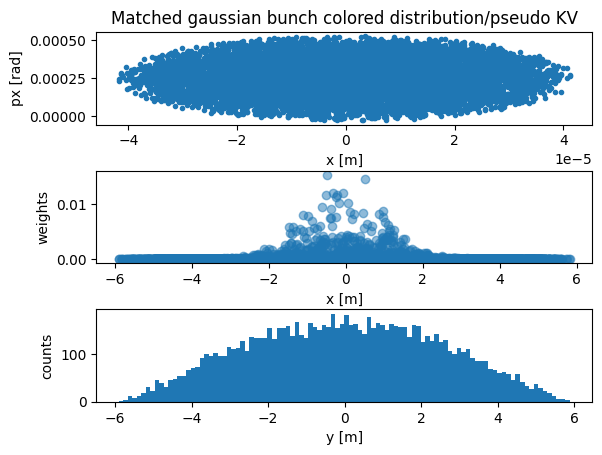

In [14]:
starting_x_c = ctx.nparray_from_context_array(gaussian_bunch_colored.x).copy()
plt.subplot(3,1,1)
plt.plot(gaussian_bunch_colored.x, gaussian_bunch_colored.px, '.')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')
plt.title('Matched gaussian bunch colored distribution/pseudo KV')

plt.subplot(3,1,2)
plt.scatter(df_colored['x'],df_colored['weights'], cmap='viridis', alpha=0.5)
plt.xlabel('x [m]')
plt.ylabel('weights')
plt.subplots_adjust(hspace=0.5)

plt.subplot(3,1,3)
plt.hist(df_colored['y'], bins=100)
plt.xlabel('y [m]')
plt.ylabel('counts')

GOBACK to Gaussian: Let's plot the bunch in the transverse plane and the histogram of the particles.

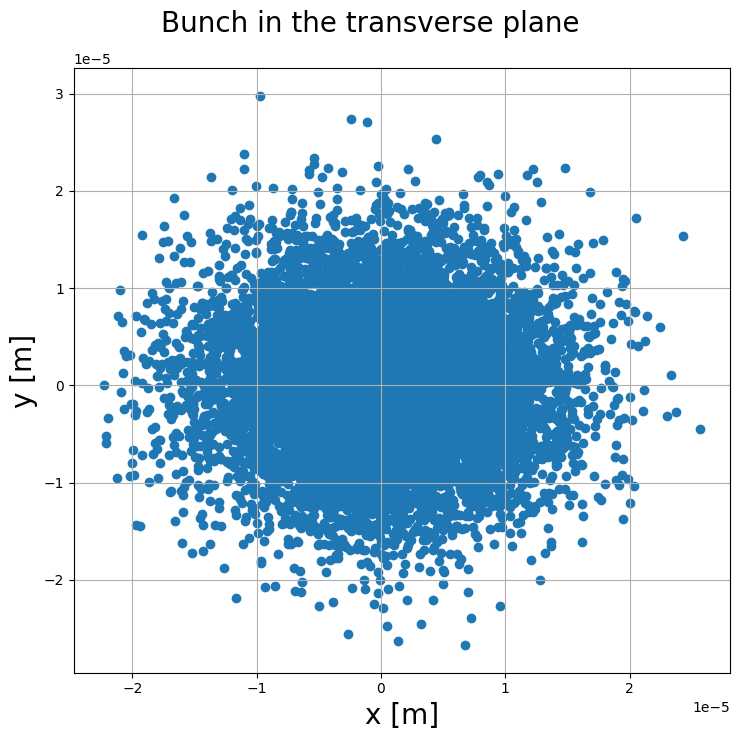

In [15]:
starting_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
starting_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
starting_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7.5, 7.5)
fontsize = 20
fig.suptitle('Bunch in the transverse plane', fontsize = fontsize)
ax.scatter(starting_x, starting_y)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.set_ylabel('y [m]', fontsize = fontsize)
ax.grid()
plt.tight_layout()

0.0
150
2.4494111463698673e-06


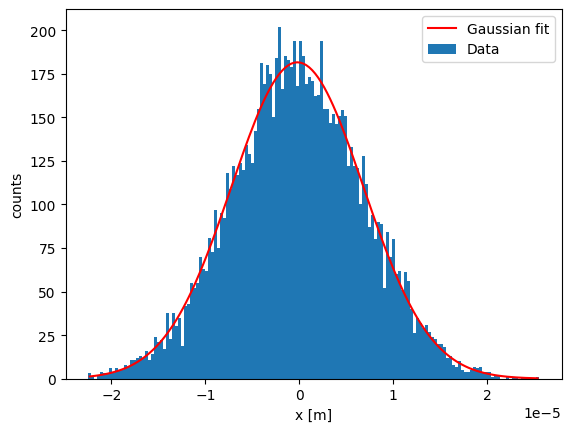

In [16]:
#plt.hist(starting_y,
#          bins=150)
D1 = twiss_b1['dx', 'ip1']
D2 = twiss_b1['dy', 'ip1']
off_mom = twiss_b1['delta','ip1']
#off_mom = line.particle_ref.delta[0]
betx_ip1 = twiss_b1['betx', 'ip1']
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
print(off_mom)
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(starting_x, bins = 150)

counts = hist
print(len(counts))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

initial_guess = [250., 0., 1e-4]

fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

# Extract fitted parameters
amplitude_fit, mean_fit, stddev_fit = fit_params

# Generate the fitted Gaussian curve
y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)

plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit', color='red')
plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], label='Data')
plt.xlabel('x [m]')
plt.ylabel('counts')
plt.legend()

#emittance_start = betx_rel * gamma_rel / betx_ip1 * (stddev_fit**2 + (D1 * off_mom)**2)

emittance_start = betx_rel * gamma_rel/ betx_ip1 * (stddev_fit**2 - (D1 * off_mom)**2)

print(emittance_start)

Let's track the bunch for 10 turns along the collider.

Then we compare the starting and ending distributions. We will see that the distribution changes, as expected.

In [17]:
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
sigma_delta: float = float(np.std(gaussian_bunch.delta))

sigma_x: float = float(np.std(gaussian_bunch.x))
sigma_y: float = float(np.std(gaussian_bunch.y))
geom_epsx: float = (sigma_x**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]
geom_epsy: float = (sigma_y**2 - (twiss_b1.dy[0] * sigma_delta)**2) / twiss_b1.bety[0]

print('Emittance geometrical x = ', geom_epsx)

geom_epsx: float = (sigma_x**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]
norm_emitt_x = geom_epsx * particle_ref._gamma0[0]  * particle_ref._beta0[0]

print('Emittance normalized x = ', norm_emitt_x)

print(betx_rel)
print(gamma_rel)

Emittance geometrical x =  4.0600101548224704e-13
Emittance normalized x =  3.0289796730682052e-09
0.9999999910167907
7460.522473526161


In [18]:
betx_rel
particle_ref._gamma0[0] 
particle_ref._beta0[0]

0.9999999910167906

In [19]:
emittance_start = betx_rel * gamma_rel / betx_ip1 * (sigma_x**2 + (twiss_b1.dx[0] * sigma_delta)**2)
print(emittance_start)

2.4482800614210346e-06


In [20]:
N_turns = 200
line.track(gaussian_bunch, num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)


In [21]:
ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
len(ending_x)


10000

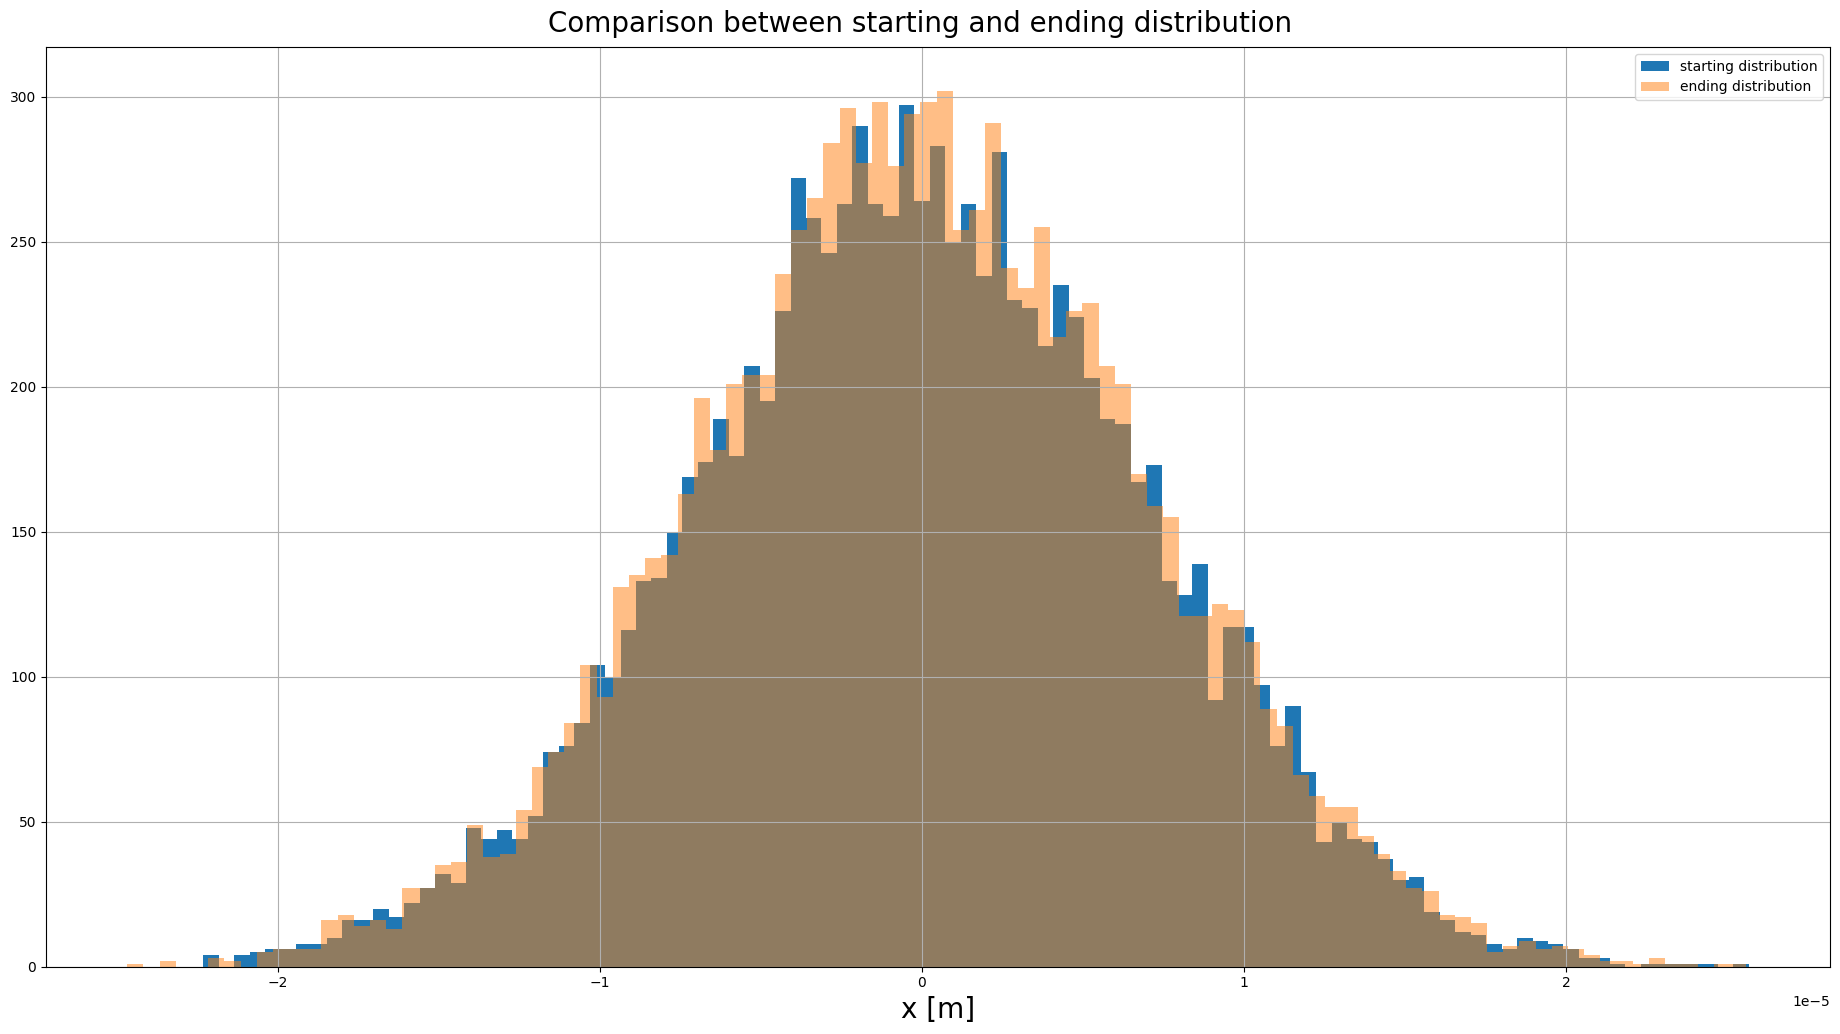

In [22]:
ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Comparison between starting and ending distribution', fontsize = fontsize)
ax.hist(starting_x, bins = 100, label = 'starting distribution')
ax.hist(ending_x, bins = 100, label = 'ending distribution', alpha = 0.5)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.grid()
ax.legend()
plt.tight_layout()

100


Text(0, 0.5, 'counts')

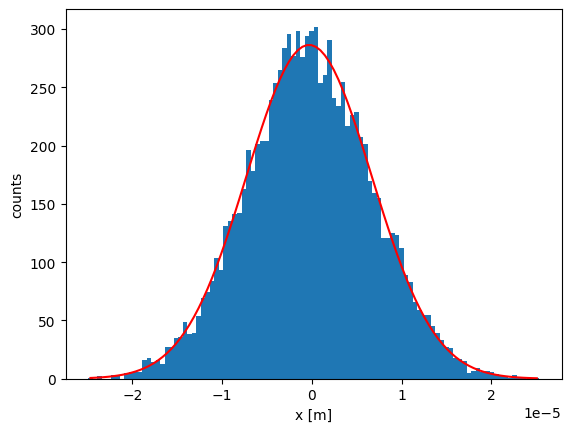

In [23]:
#Gaussian fit
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(ending_x, bins = 100)

counts = hist
print(len(counts))

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

initial_guess = [16., 0., 1e-4]

fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

# Extract fitted parameters
amplitude_fit, mean_fit, stddev_fit = fit_params

# Generate the fitted Gaussian curve
y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)

plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit', color='red')
plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0],)
plt.xlabel('x [m]')
plt.ylabel('counts')




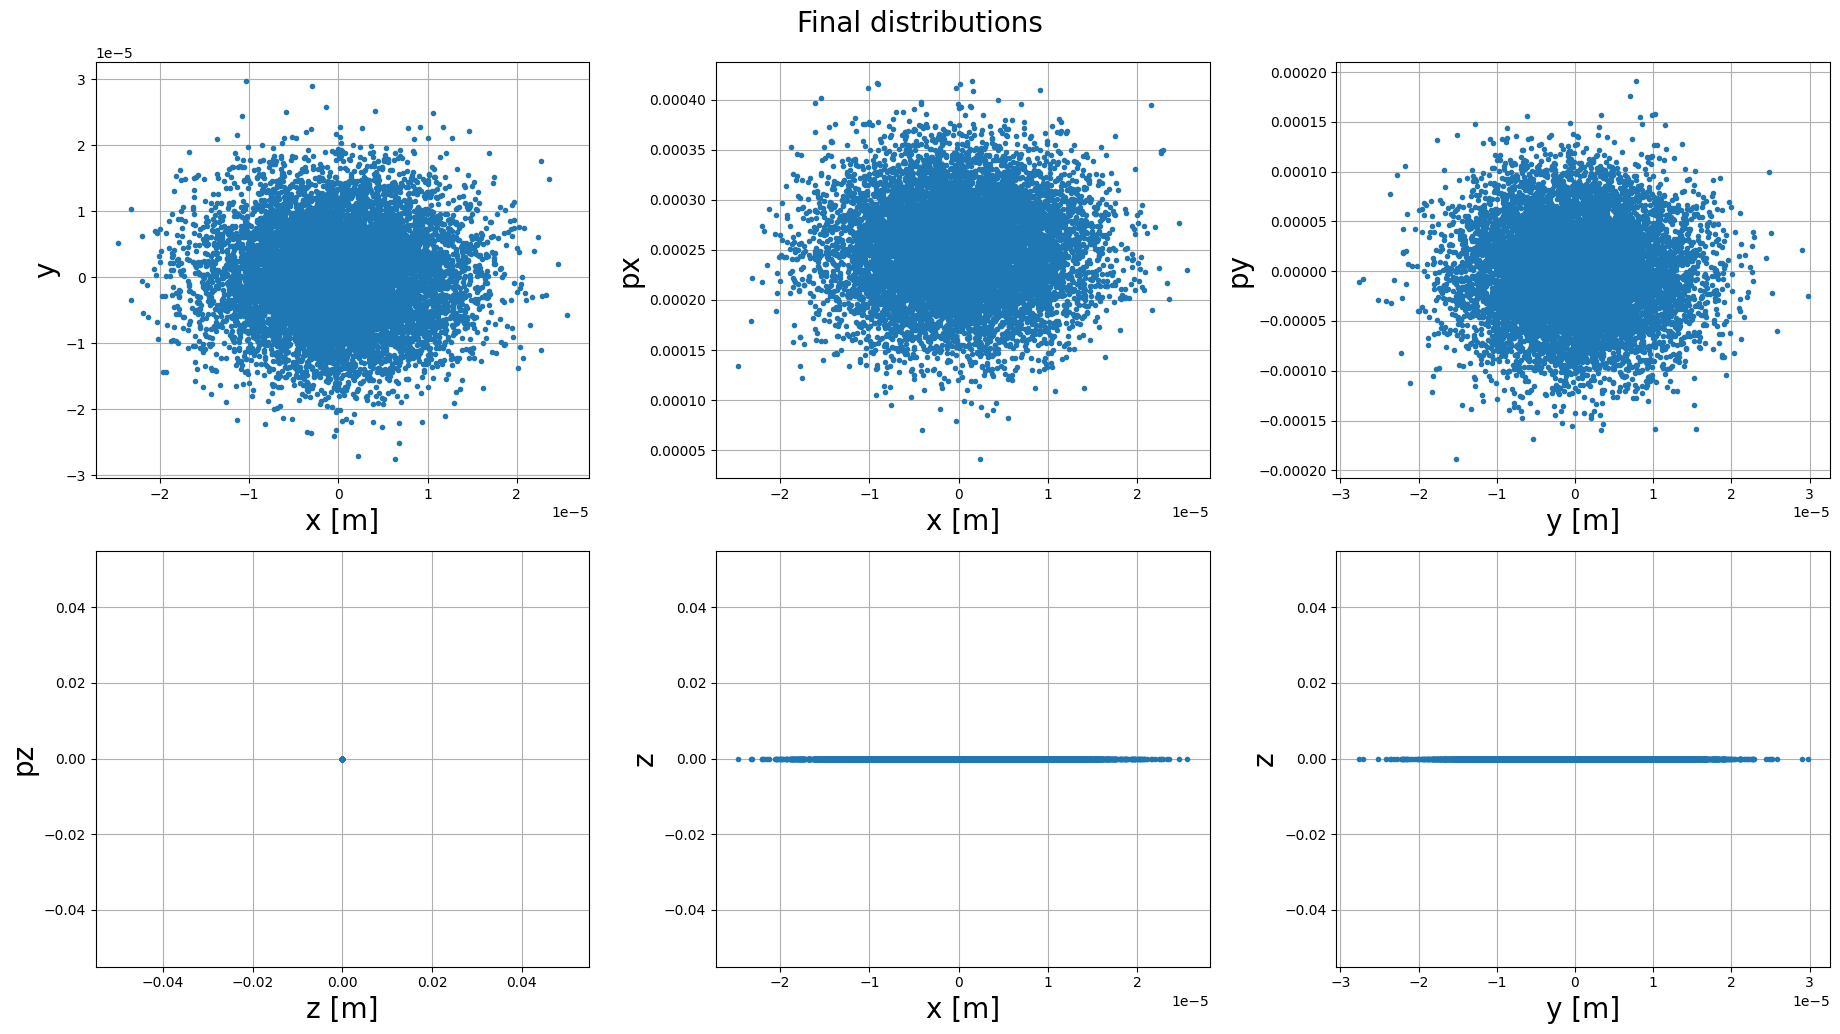

In [24]:
fontsize = 20
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Final distributions' , fontsize = fontsize)


ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()


plt.subplot(2,3,1)
plt.plot(ending_x, ending_y, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('y', fontsize = fontsize)
plt.grid()


plt.subplot(2,3,2)
plt.plot(ending_x, ending_px, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('px', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,3)
plt.plot(ending_y, ending_py, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('py', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,4)
plt.plot(ending_zeta, ending_pz, '.')
plt.xlabel('z [m]', fontsize = fontsize)
plt.ylabel('pz', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,5)
plt.plot(ending_x, ending_zeta, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,6)
plt.plot(ending_y, ending_zeta, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()




plt.tight_layout()

In [25]:
x_data = collider['lhcb1'].record_last_track.x


y_data = collider['lhcb1'].record_last_track.y
px_data = collider['lhcb1'].record_last_track.px
py_data = collider['lhcb1'].record_last_track.py
zeta_data = collider['lhcb1'].record_last_track.zeta
pz_data = collider['lhcb1'].record_last_track.pzeta
print(x_data.shape)

(10000, 200)


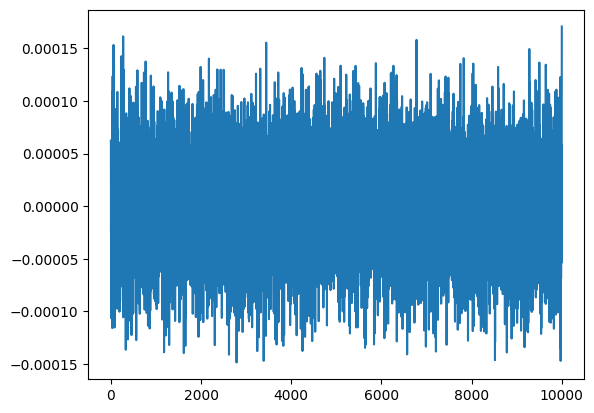

In [26]:
plt.plot(x_data[:,0]/betx_ip1)


# Emittance

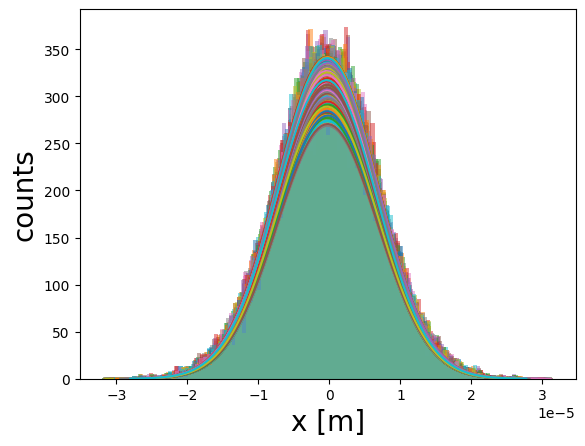

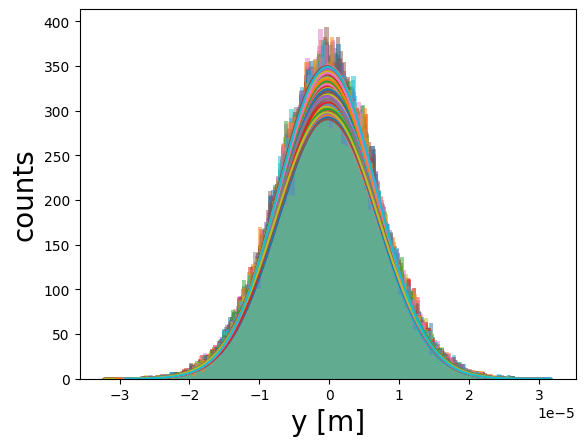

In [27]:
# Gaussian fit and standard deviation

def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

stddev_x = []

for i in range(N_turns):#[16,18]:
    #plt.hist(x_data[:,i*500], bins = 100)
    #hist, bin_edges = np.histogram(x_data[:, i*500], bins = 100)
    hist, bin_edges = np.histogram(x_data[:,  i], bins = 100)
    #print(i)

    counts = hist
    #print(len(counts))
    
    initial_guess = [16., 0., 1e-4]

    fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

    # Extract fitted parameters
    amplitude_fit, mean_fit, stddev_fit = fit_params

    # Generate the fitted Gaussian curve
    y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)
    stddev_x.append(stddev_fit)

    #plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i*500))
    plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i))
    #plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i*500))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i))
    
    plt.xlabel('x [m]', fontsize = fontsize)
    plt.ylabel('counts', fontsize = fontsize)
    #plt.legend()
    plt.grid()
    
stddev_y = []
plt.figure()

for i in range(N_turns):
    #plt.hist(x_data[:,i*500], bins = 100)
    #hist, bin_edges = np.histogram(y_data[:, i*500], bins = 100)
    hist, bin_edges = np.histogram(y_data[:, i], bins = 100)
    #print(i*500)

    counts = hist
    #print(len(counts))
    
    initial_guess = [16., 0., 1e-4]

    fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

    # Extract fitted parameters
    amplitude_fit, mean_fit, stddev_fit = fit_params

    # Generate the fitted Gaussian curve
    y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)
    stddev_y.append(stddev_fit)

    #plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i*500))
    plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i*500))
    plt.xlabel('y [m]', fontsize = fontsize)
    plt.ylabel('counts', fontsize = fontsize)
    #plt.legend()
    plt.grid()
    

#normal_emitt_x = 2.5e-6 #m*rad




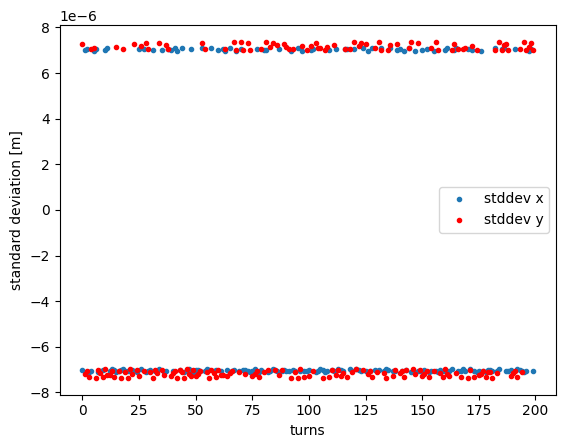

In [28]:
plt.plot(stddev_x, '.', label = 'stddev x')
plt.plot(stddev_y, '.', color = 'red', label = 'stddev y')
plt.xlabel('turns')
plt.ylabel('standard deviation [m]')
plt.legend()

Dispersion D1 =  -0.0012120581001410907
Off momentum =  [0.]
Beta function optical IP1 =  121.39633715003635
Beta relativistic = 0.9999999910167907
Gamma relativistic = 7460.522473526161
Mean emittance x =  3.04596976381073e-09
Mean emittance y =  3.156159240897506e-09


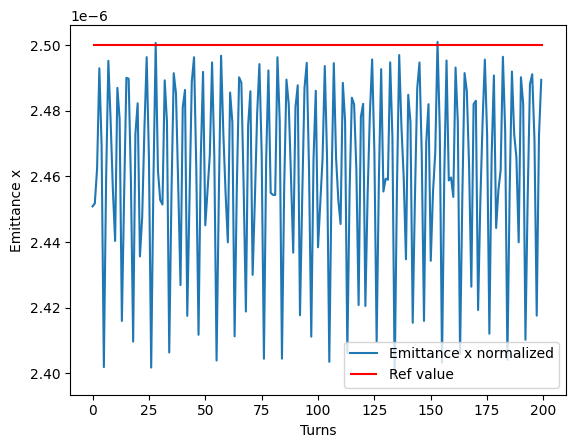

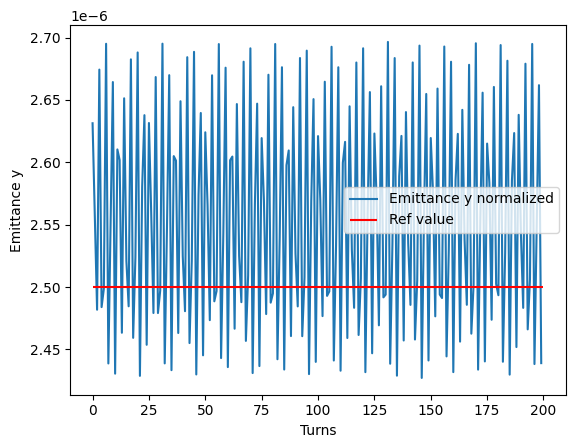

In [29]:
#D = twiss_b1.dx[0]
# Emittance calculation
'''
D1 = twiss_b1['dx', 'ip1']
D2 = twiss_b1['dy', 'ip1']
off_mom = twiss_b1['delta','ip1']
#off_mom = line.particle_ref.delta[0]
betx_ip1 = twiss_b1['betx', 'ip1']
'''
D1 = twiss_b1['dx', 'ip1']
D2 = twiss_b1['dy', 'ip1']

off_mom = line.particle_ref.delta
betx_ip1 = twiss_b1.betx[0]

gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
emittx = []
emitty = []
geomx_all = []
normx_all = []
geomy_all = []
normy_all = []

print('Dispersion D1 = ', D1)
print('Off momentum = ', off_mom)
print('Beta function optical IP1 = ', betx_ip1)
print('Beta relativistic =', betx_rel)
print('Gamma relativistic =', gamma_rel)

sigma_delta: float = float(np.std(gaussian_bunch.delta))
sigma_x: float = float(np.std(gaussian_bunch.x))
sigma_y: float = float(np.std(gaussian_bunch.y))




geom_epsx: float = (sigma_x**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]
geom_epsy: float = (sigma_y**2 - (twiss_b1.dy[0] * sigma_delta)**2) / twiss_b1.bety[0]

#print('Emittance x = ', geom_epsx)

geom_epsx: float = (sigma_x**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]

gaussian_bunch.x

for i in range(N_turns):
    #emittance_tryx = betx_rel * gamma_rel / betx_ip1 * (stddev[i]**2 + (D1 * off_mom)**2)
    #emittance_tryy = betx_rel * gamma_rel / betx_ip1 * (stddev_y[i]**2 - (D2 * off_mom)**2)

    emittance_tryx = gamma_rel*betx_rel / betx_ip1 * (stddev_x[i]**2 - (D1 * off_mom)**2)
    emittance_tryy = gamma_rel*betx_rel / betx_ip1 * (stddev_y[i]**2 - (D2 * off_mom)**2)
    #emittance_tryx = gamma_rel*betx_rel* (stddev[i]**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]
    #emittance_tryy = gamma_rel*betx_rel* (stddev_y[i]**2 - (twiss_b1.dy[0] * sigma_delta)**2) / twiss_b1.betx[0]

    geomx_emittance = (stddev_x[i]**2-tw0[:,0]["dx"][0]*sigma_delta)/tw0[:,0]["betx"][0]
    normx_emittance = geomx_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    #print('Emittance x = ', normx_emittance)
   
    geomx_all.append(geomx_emittance)
    normx_all.append(normx_emittance)

    geomy_emittance = (stddev_y[i]**2-tw0[:,0]["dy"][0]*sigma_delta)/tw0[:,0]["bety"][0]
    normy_emittance = geomy_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    geomy_all.append(geomy_emittance)
    normy_all.append(normy_emittance)
    #print('Emittance y = ', normy_emittance)

    emittx.append(emittance_tryx)
    emitty.append(emittance_tryy)

#print('Emittance x = ', emittx)
#print('Emittance y = ', emitty)

#plt.plot(np.arange(N_turns), emittx, label = 'Emittance x')
plt.plot(np.arange(N_turns), normx_all, label = 'Emittance x normalized')
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.xlabel('Turns')
plt.ylabel('Emittance x')
plt.legend()

print('Mean emittance x = ', np.mean(emittx))
print('Mean emittance y = ', np.mean(emitty))

plt.figure()
#plt.plot(np.arange(N_turns), emitty, label = 'Emittance y')
plt.plot(np.arange(N_turns), normy_all, label = 'Emittance y normalized')
plt.xlabel('Turns')
plt.ylabel('Emittance y')
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.legend()

e_x = betx

emittancex_all = []
emittancey_all = []
for i in range(len(stddev_x)):
    emittance = (stddev_x[i])**2*gamma_rel*betx_rel/betx_ip1
    emittancey = (stddev_y[i])**2*gamma_rel*betx_rel/betx_ip1
    emittancex_all.append(emittance)
    emittancey_all.append(emittancey)
    

#emittancey_all = []

# normal_emitt_x = 2.5e-6 #m*rad


[[ 3.87550196e-01  4.74612107e-17  8.81540511e-05  2.90033670e-05
   4.84840108e-07 -4.59343207e-05]
 [ 4.59963898e-03  2.58031076e+00 -2.62582812e-04  6.03688298e-04
   9.12554707e-08 -2.24347869e-04]
 [-9.05585160e-05  2.89879146e-05  3.87286968e-01  4.74289746e-17
  -1.44541810e-06 -1.65366328e-04]
 [-2.61882785e-04 -5.87958130e-04 -8.35331137e-03  2.58206453e+00
  -4.17466844e-06  1.50341590e-03]
 [ 2.30891683e-03 -3.14919060e-03 -1.53340329e-02 -1.12387473e-02
   2.63741815e+01  3.22990570e-15]
 [-4.67299635e-09 -3.96785381e-08 -2.39043001e-08  1.68959841e-07
  -6.46601842e-05  3.79158686e-02]]
[[ 3.87550196e-01  4.74612107e-17  8.81540511e-05  2.90033670e-05
   4.84840108e-07 -4.59343207e-05]
 [ 4.59963898e-03  2.58031076e+00 -2.62582812e-04  6.03688298e-04
   9.12554707e-08 -2.24347869e-04]
 [-9.05585160e-05  2.89879146e-05  3.87286968e-01  4.74289746e-17
  -1.44541810e-06 -1.65366328e-04]
 [-2.61882785e-04 -5.87958130e-04 -8.35331137e-03  2.58206453e+00
  -4.17466844e-06  1.503

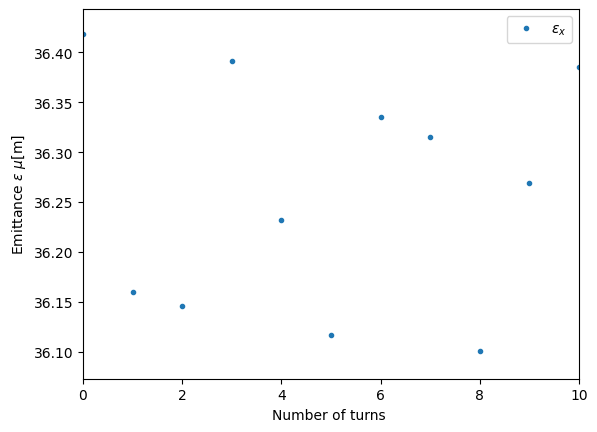

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


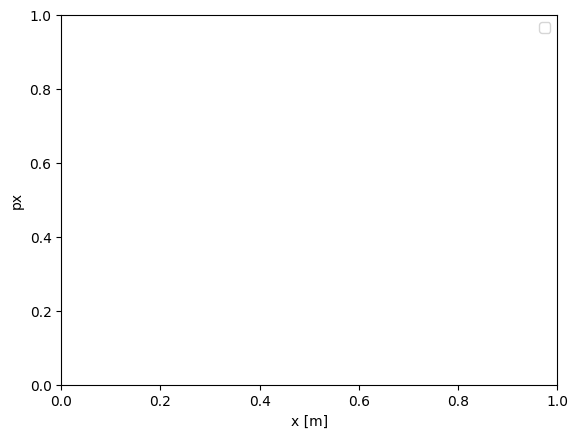

In [30]:
import scipy.constants
W = line.twiss()['W_matrix'][0]
print(W)
W_inv = np.linalg.inv(W)
tw_full_inverse = line.twiss(use_full_inverse=True)['W_matrix'][0]
print(tw_full_inverse)


array_6D = np.array([x_data.tolist(), y_data.tolist(), px_data.tolist(), py_data.tolist(), zeta_data.tolist(), pz_data.tolist()])

array_6D.shape
array_6D_norm = np.zeros_like(array_6D)
print(array_6D_norm.shape)


for i in range(N_particles):
    for j in range(N_turns):
        norm = tw_full_inverse @ array_6D[:,i,j]
        array_6D_norm[:,i,j] = norm

array_6D_norm.shape


Jx = np.zeros((N_turns, N_particles))
Jy = np.zeros((N_turns, N_particles)) 
errorx = np.zeros(N_turns)
errory = np.zeros(N_turns)
num_repetitions = 1

for i in range(N_turns):
    Jx[i,:] = (pow(array_6D_norm[0,:, i],2)+pow(array_6D_norm[2, :, i],2))/2 
    Jy[i,:] = (pow(array_6D_norm[1,:, i],2)+pow(array_6D_norm[3, :, i],2))/2
    num_particles_at_turn = N_particles 
    errorx[i] = np.nanstd(Jx[i])/(np.sqrt(num_particles_at_turn))*(betx_rel*gamma_rel)
    errory[i] = np.nanstd(Jy[i])/(np.sqrt(num_particles_at_turn))*(betx_rel*gamma_rel)




#x_axis = np.linspace(1, N_turns, N_turns)
#_axis = x_axis*26000/(scipy.constants.c*60)

emitx = np.nanmean(Jx, axis=1)*(betx_rel*gamma_rel)
emity = np.nanmean(Jy, axis=1)*(betx_rel*gamma_rel)

plt.plot(emitx*1e6, '.')
#plt.plot(emity*1e6, '.')
plt.xlabel('Number of turns ')
plt.ylabel('Emittance $\epsilon$ $\mu$[m]')
plt.legend(['$\epsilon_x$', '$\epsilon_y$'])
plt.xlim(0,10)
plt.show()


#plt.plot(array_6D_norm[0, 0, :]/1e-6, array_6D_norm[2, 0, :]/1e-6, '.', label = 'Normalized coordinates')
#plt.plot(array_6D[0,0,:], array_6D[2,0,:], '.', label = 'Real coordinates')
plt.xlabel('x [m]')
#plt.xlim(-0.0002, 0.0005)
#plt.ylim(0.0003,0.001)
plt.ylabel('px')
plt.legend()
#normalized_coordinates_array = np.einsum('ij,jki->ikj', W_inv, array_6D)

In [31]:

# Function to calculate the inverse of each 6x6 matrix
def calculate_inverse(matrix):
    try:
        inv_matrix = np.linalg.inv(matrix)
        return inv_matrix
    except np.linalg.LinAlgError:
        # Matrix is singular (non-invertible)
        return None

# Calculate inverses for all matrices
W_inv_list = [calculate_inverse(matrix) for matrix in W]

# Convert the list of inverses back to a NumPy array
W_inv = np.array(W_inv_list)

# Print the original shape of W_inv
print("Shape of W_inv:", W_inv.shape)
print(emittancex_all)
print(emittancey_all)
print(off_mom)
print(D1)
# Access a specific inverse matrix (for example, the first one)
print("Inverse Matrix W^-1 for the first matrix:")
print(W_inv[0])

# Extract the (1, 1) elements from each 6x6 matrix
element_11_values = [matrix[0,0] for matrix in W_inv]

plt.plot(element_11_values)

Shape of W_inv: (6,)
[3.032297825150577e-09, 3.0334261560778907e-09, 3.0465459208738696e-09, 3.084391648042931e-09, 3.0553384495929203e-09, 2.9716355567102543e-09, 3.042321687686904e-09, 3.0872120091716363e-09, 3.0647782892004276e-09, 3.0385871432407936e-09, 3.0192437463377835e-09, 3.0770107755129683e-09, 3.0652185481066475e-09, 2.989069020084688e-09, 3.036615612041303e-09, 3.0808089445874135e-09, 3.080453976114346e-09, 3.042317972880115e-09, 2.981267008430369e-09, 3.059646318374761e-09, 3.071186162165927e-09, 3.0134068425381944e-09, 3.028112019509942e-09, 3.0616550018489906e-09, 3.088594749640803e-09, 3.0506761657354552e-09, 2.9714749001949394e-09, 3.042383865973467e-09, 3.0939476882342406e-09, 3.0457571657178175e-09, 3.0346899649985505e-09, 3.0329866155484673e-09, 3.079840817538479e-09, 3.064031697590097e-09, 2.9771524281610783e-09, 3.037317678812758e-09, 3.0825349011358695e-09, 3.0748686956597636e-09, 3.0397958055435627e-09, 3.0026015248191697e-09, 3.069693892172793e-09, 3.076220712

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# using the action
print(len(x_data[:,0]))
J = np.zeros((len(x_data[:,0]), len(x_data[0,:])))


for i in range(len(x_data[:,0])):
    J[:,i] = (x_data[i,0]**2 + px_data[i,0]**2) / 2


10000


IndexError: index 20 is out of bounds for axis 1 with size 20

0.0 0.0


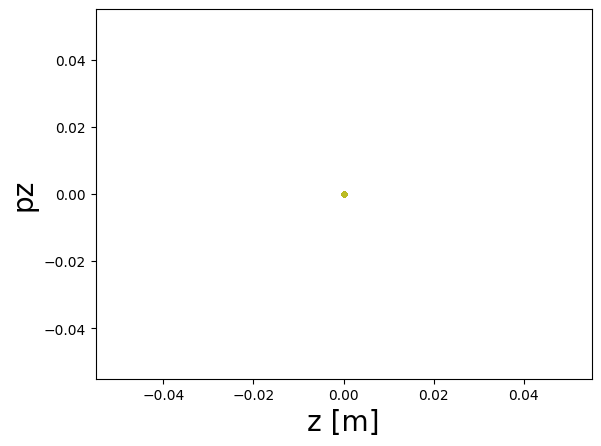

In [ ]:
#for i in range(len(x_data[0:1000])):
for i in range(len(x_data.T)-1):
   plt.plot(zeta_data.T[i], pz_data.T[i], '.')
plt.xlabel('z [m]', fontsize = fontsize)
plt.ylabel('pz', fontsize = fontsize)
#plt.xlim(zeta_data.flatten().min(), zeta_data.flatten().max())
#plt.ylim(pz_data.flatten().min(), pz_data.flatten().max())
#plt.axvline(0.2, color = 'red')
print(zeta_data.flatten().min(), zeta_data.flatten().max())

## Emmitance one snapshot


0.00020574112997480951 4.210664210235182e-06 4.690406357388803e-10
0.00026001780948232045 5.770969298385752e-06 4.686496057073558e-10
0.00025996677672897263 4.6755635901414325e-06 4.688595204850667e-10
0.00020579362696799874 4.790800765527345e-06 4.690835583459241e-10
0.00028131294881083375 5.728732944173329e-06 4.687565115264161e-10
0.00022546594822362969 4.168009606432e-06 4.691194931799864e-10
0.00023508196163403314 5.477114100739582e-06 4.690108201062794e-10
0.0002777163358865688 5.2026137310449706e-06 4.689890292523812e-10
0.00020217955246598645 4.325690337759321e-06 4.691563521296607e-10
0.0002679195310354009 5.814112239195407e-06 4.687746273788806e-10
0.00025103630459245233 4.492358743280805e-06 4.690887343842949e-10
0.00021179764176038009 4.991476818081258e-06 4.689476865300062e-10
0.00028291022879698915 5.62442424623704e-06 4.68622901330145e-10
0.00021670528419606282 4.136607367810948e-06 4.690474999405593e-10
0.000244807851806789 5.615263551215435e-06 4.687025672425885e-10
0.

20

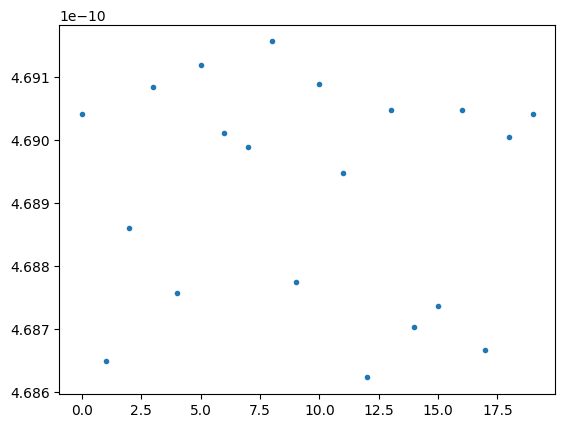

In [ ]:
# Emittance
emit_x_all = []
for i in range(len(x_data.T)):

    rms_x = np.sqrt(np.mean(x_data.T[i]**2))
    rms_y = np.sqrt(np.mean(y_data.T[i]**2))
    rms_z = np.sqrt(np.mean(zeta_data.T[i]**2))
    rms_px = np.sqrt(np.mean(px_data.T[i]**2))
    rms_py = np.sqrt(np.mean(py_data.T[i]**2))
    rms_pz = np.sqrt(np.mean(pz_data.T[i]**2))



    cov_matrix_x = np.cov(x_data.T[i], px_data.T[i])
    cov_matrix_y = np.cov(y_data.T[i], py_data.T[i])
    cov_matrix_z = np.cov(zeta_data.T[i], pz_data.T[i])
    cross_term_x = cov_matrix_x[0,1]
    cross_term_y = cov_matrix_y[0, 1]
    cross_term_z = cov_matrix_z[0, 1]
    # Compute the emittance using RMS values and the cross-correlation term
    emit_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cross_term_x ** 2)
    emit_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cross_term_y ** 2)
    emit_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cross_term_z ** 2)

    emit_x_all.append(emit_x)
    
    print(rms_x, rms_px, emit_x)

plt.plot(emit_x_all, '.')
len(emit_x_all)



In [ ]:
dx = collider.lhcb1.twiss().to_pandas().iloc[0]["dx"]
dy = collider.lhcb1.twiss().to_pandas().iloc[0]["dy"]



In [ ]:
twiss_b1.betx

array([121.39633715, 121.39633715,  47.90294102, ..., 224.87735273,
       121.39633886, 121.39633886])

If determinant = 0, a singularity.. problematic check data: det =  0.0
-3.706113184501986e-12 -3.5576358757401693e-12 0.0
disp contr 2.5293871238408312e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
8.278097345029038e-12 -1.1705629859136224e-12 0.0
disp contr 2.5294303745628256e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
-5.928882552401316e-12 1.348925156678187e-12 0.0
disp contr 2.5295211720892034e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
2.738068700776443e-12 -4.2143983157883205e-12 0.0
disp contr 2.529615352961553e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
4.304110392039342e-12 2.9887627575587653e-13 0.0
disp contr 2.529820973376464e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
-6.5998298446345605e-12 1.1829873831621407e-13 0.0
disp contr 2.530047798092269e-06
If determinant = 0, a singularity.. problematic check data: det =  0.0
7.

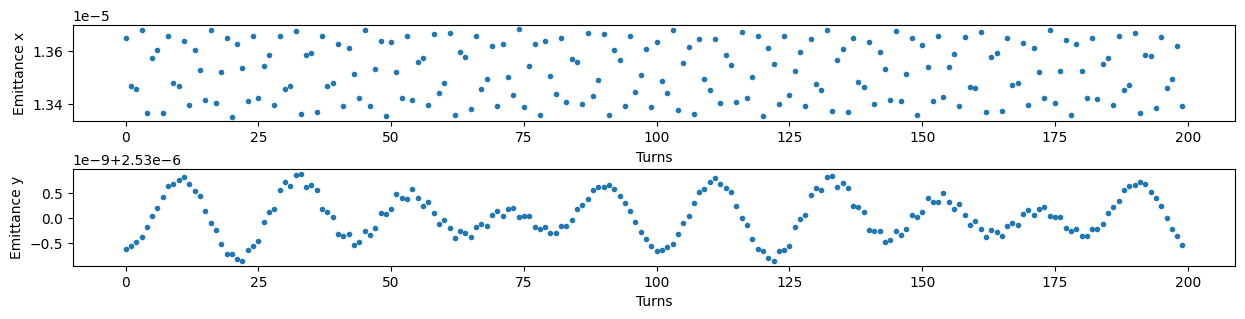

In [ ]:
import numpy as np

# Assuming x_data, y_data, z_data, px_data, py_data, pz_data are arrays/lists containing respective data
emittance_x_all = []
emittance_y_all = []
emittance_z_all = []
total_all = []
# Calculate mean values for x, y, z, px, py, pz
for i in range(len(x_data.T)):
    mean_x = np.mean(x_data.T[i])
    mean_y = np.mean(y_data.T[i])
    mean_z = np.mean(zeta_data.T[i])
    mean_px = np.mean(px_data.T[i])
    mean_py = np.mean(py_data.T[i])
    mean_pz = np.mean(pz_data.T[i])

    # Calculate RMS values for x, y, z, px, py, pz
    rms_x = np.sqrt(np.mean(np.square(x_data.T[i])))
    rms_y = np.sqrt(np.mean(np.square(y_data.T[i])))
    rms_z = np.sqrt(np.mean(np.square(zeta_data.T[i] - mean_z)))
    rms_px = np.sqrt(np.mean(np.square(px_data.T[i])))
    rms_py = np.sqrt(np.mean(np.square(py_data.T[i])))
    rms_pz = np.sqrt(np.mean(np.square(pz_data.T[i] - mean_pz)))

    # Calculate the covariance matrix for position and momentum
    data_matrix = np.array([x_data.T[i], y_data.T[i], zeta_data.T[i], px_data.T[i], py_data.T[i], pz_data.T[i]])
    cov_matrix = np.cov(data_matrix)
    print('If determinant = 0, a singularity.. problematic check data: det = ', np.linalg.det(cov_matrix))
    #plt.plot(np.linalg.det(cov_matrix), '.')
    

    # Extract the covariance terms between different dimensions
    cov_x_px = cov_matrix[0, 3]  # Covariance between x and px
    

    cov_y_py = cov_matrix[1, 4]  # Covariance between y and py
    cov_z_pz = cov_matrix[2, 5]  # Covariance between z and pz
    print(cov_x_px, cov_y_py, cov_z_pz)

    dispersion_contribution_x = np.square(D1) * rms_x ** 2
    print('disp contr', np.sqrt(rms_py**2*rms_y**2-cov_y_py**2)*gamma_rel*betx_rel)


    # Compute emittance in each direction
    emittance_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2)
    emittance_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)
    #emittance_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)
    #total_emittance = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2) * np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)#* np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)

    emittance_x_all.append(emittance_x*gamma_rel*betx_rel)
    emittance_y_all.append(emittance_y*gamma_rel*betx_rel)
    #emittance_z_all.append(emittance_z)
    
    #total_all.append(total_emittance)


print("Emittance in x-direction:", np.mean(emittance_x_all))
print("Emittance in y-direction:", np.mean(emittance_y_all))
#print("Emittance in z-direction:", emittance_z)


plt.figure(figsize=(15, 5))
plt.subplot(3,1,1)
plt.xlabel('Turns')
plt.ylabel('Emittance x')
plt.plot(emittance_x_all, '.')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,2)
plt.plot(emittance_y_all, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance y')
'''
plt.subplot(3,1,3)
plt.plot(total_emittance, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance total')
'''

print(line.twiss().dx)  #dx: horizontal dispersion (d x / d delta) in meters

In [ ]:
import PyNAFF
qx_i = []
qy_i = []
for ii in range(len(x_data.T[0])):
    qx_i.append(PyNAFF.naff(x_data[ii,:], turns=N_turns-1)[0][1])
    qy_i.append(PyNAFF.naff(y_data[ii,:], turns=N_turns-1)[0][1])

Indices for filtered_values_x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

(0.28, 0.36)

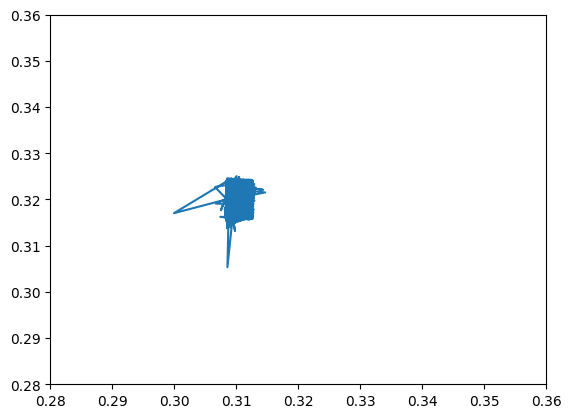

In [ ]:
filtered_values_x = list(filter(lambda x: x > 0.2, qx_i))
filtered_values_y = list(filter(lambda x: x > 0.2, qy_i))
#plt.plot(filtered_values_x, filtered_values_y)
indices_x = [i for i, val in enumerate(qx_i) if val > 0.2]
indices_y = [i for i, val in enumerate(qy_i) if val > 0.2]

print("Indices for filtered_values_x:", indices_x)
print("Indices for filtered_values_y:", indices_y)

print('Tune x:', np.mean(filtered_values_x))
print('Tune y:', np.mean(filtered_values_y))
common_indices = list(set(indices_x).intersection(indices_y))

values_from_qx_i = [qx_i[idx] for idx in common_indices]

values_from_qy_i = [qy_i[idx] for idx in common_indices]
plt.plot(values_from_qx_i, values_from_qy_i)
plt.xlim(0.28, 0.36)
plt.ylim(0.28, 0.36)

Tracking particles for footprint...


Done tracking.
Computing footprint...
Done computing footprint.


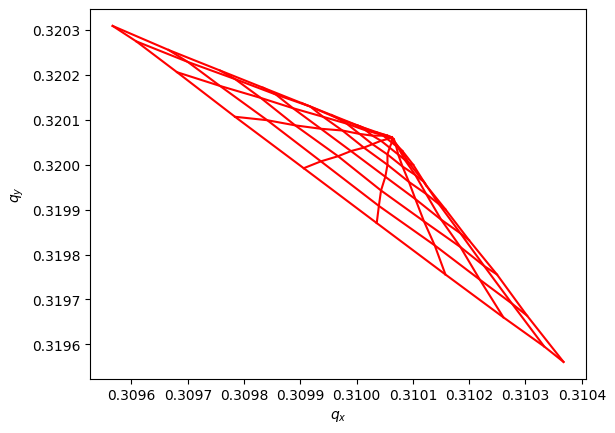

In [ ]:
fp0_jgrid = collider['lhcb1'].get_footprint(nemitt_x=normal_emitt_x, nemitt_y=normal_emitt_y,
                            mode='polar')
fp0_jgrid.plot(color='red')

In [ ]:
len(zeta_data.T)
std_x = np.std(x_data.T[0])
std_y = np.std(y_data.T[0])
std_z = np.std(zeta_data.T[0])
std_px = np.std(px_data.T[0])
std_py = np.std(py_data.T[0])
std_pz = np.std(pz_data.T[0])

cov_x_xp = np.cov(x_data.T[0], px_data.T[0])[0][1]
cov_y_yp = np.cov(y_data.T[0], py_data.T[0])[0][1]
cov_z_zp = np.cov(zeta_data.T[0], pz_data.T[0])[0][1]
cov_x_z = np.cov(x_data.T[0], zeta_data.T[0])[0][1]
cov_y_z = np.cov(y_data.T[0], zeta_data.T[0])[0][1]
cov_pz_py = np.cov(pz_data.T[0], py_data.T[0])[0][1]

# Emittance
emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
print('Emmitance: ', emitt)


Emmitance:  8.162023810150152e-10


/tmp/ipykernel_118076/2354880011.py:16: RuntimeWarning: invalid value encountered in sqrt
  emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)


Text(0, 0.5, 'Emittance $\\epsilon $')

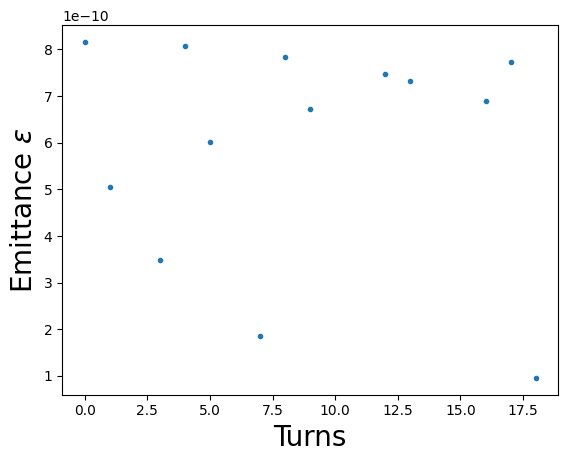

In [ ]:
emitt_all = []
for i in range(len(x_data.T)):
    std_x = np.std(x_data.T[i])
    std_y = np.std(y_data.T[i])
    std_z = np.std(zeta_data.T[i])
    std_px = np.std(px_data.T[i])
    std_py = np.std(py_data.T[i])
    std_pz = np.std(pz_data.T[i])

    # That is for the correlation between the planes
    cov_x_xp = np.cov(x_data.T[i], px_data.T[i])[0][1]   
    cov_x_z = np.cov(x_data.T[i], zeta_data.T[i])[0][1]
    cov_y_z = np.cov(y_data.T[i], zeta_data.T[i])[0][1]

    # Emittance
    emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
    emitt_all.append(emitt)

plt.plot(emitt_all, '.')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance $\epsilon $', fontsize = fontsize)

9999


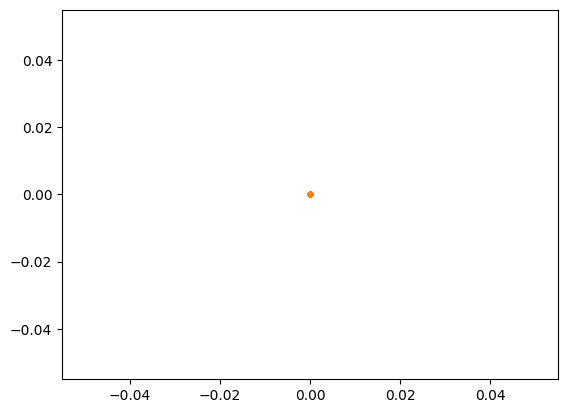

In [ ]:

plt.plot(zeta_data[0], pz_data[0].T, '.')
plt.plot(zeta_data[1], pz_data[1].T, '.')

print(len(x_data)-1)

/tmp/ipykernel_118076/3256523225.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(z_min, z_max)
/tmp/ipykernel_118076/3256523225.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(pz_min, pz_max)


IndexError: index 20 is out of bounds for axis 0 with size 20

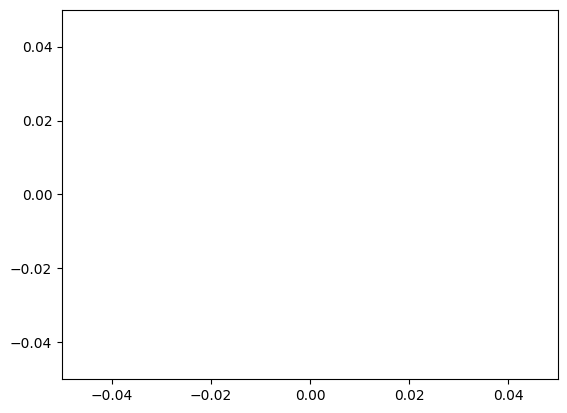

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Generating example data (replace this with your actual data)
num_points = 100
num_snapshots = 10
x_min = min(x_data.flatten())
x_max = max(x_data.flatten())
px_min = min(px_data.flatten())
px_max = max(px_data.flatten())
y_min = min(y_data.flatten())
y_max = max(y_data.flatten())
py_min = min(py_data.flatten())
py_max = max(py_data.flatten())
z_min = min(zeta_data.flatten())
z_max = max(zeta_data.flatten())
pz_min = min(pz_data.flatten())
pz_max = max(pz_data.flatten())



# Plot and save each frame as an image
images = []
for i in range(len(x_data[:])):
    plt.plot(zeta_data.T[i], pz_data.T[i], '.')
    plt.title(f"Turn {i}")
    plt.xlabel('z [m]')
    plt.ylabel('pz')
    plt.savefig(f"images/frame_{i}.png")  # Save each frame as an image
    plt.clf()  # Clear the plot for the next frame
    plt.xlim(z_min, z_max)
    plt.ylim(pz_min, pz_max)
    # Open the saved image and append it to the list of images
    img = Image.open(f"images/frame_{i}.png")
    images.append(img)

# Save the images as an animated GIF
images[0].save('animation_zeta_pz_1000turns_time.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)


In [ ]:
#images[0].save('animation_zeta_pz_1000turns.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)